# Model Build - Smoothed Series
Building and testing models notebook for Google Colab

Taking what we learnt from the last notebook, we will now model on a smoothed series instead of the raw data.

The rational is that the data is very noisy. It has outliers that would be hard to predict and they also disrupt the patterns that are typically found in the series. If we denoise the series by smoothing it, the pattern will be more apparent and thus our model can tune its parameters better.

A few filters were experimented with (e.g. Median filter). I settled on a Gaussian filter which averages out the values in the series in accordance to a normal distribution. 


Ultimately we wont be predicting the actual temperature anymore but rather a smoothed rendition of the temperature. So in the grid search I added an extra component that calcualtes MAE from scratch by comparing the preds to the actual original temperature values.


Be sure to switch to GPU in the run time


In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from scipy.ndimage import gaussian_filter1d

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#my file path to data on Gdrive
! ls drive/MyDrive/0_neural_net_weather_forecasts_on_cloud/Data

best_temp_model.h5	      results_table_temp.csv
results_table_1621536110.csv  results_table_temp_smooth.csv
results_table_1621583745.csv  temp_model.h5
results_table_1621688232.csv  weather_data.csv
results_table_1621765059.csv


In [ ]:
os.chdir('drive/MyDrive/0_neural_net_weather_forecasts_on_cloud/Data')

In [ ]:
df = pd.read_csv('weather_data.csv')

#get temp and time
df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y')
df = df.set_index('datetime')

temp = df['temp']

#split data (Save a week for testing. Train and Validation made in class)
temp_train = temp.iloc[:-7]
temp_test = temp.iloc[-7:]


##Define the model class

In [ ]:

class BuildModel():
    """
    Build a model. Arguments allow one to customise the hyper parameters
    ATTRIBUTES :- 
    length - number of steps in time sequence to feed the rnn
    layers_num - number of rnn layers in model (capped at 3)
    layers_type - select "LSTM" or "GRU"
    units - number of units in rnn layers
    num_step_preds - number of steps/days in time to predict
    dropout - dropout % to be applied to rnn units
    g_filt - gaussian filter for smoothing. Default: no smoothing
    batch_size - number of samples to feed model at a time.
    patience - how many epochs to wait before stopping model after finding good score.
    model_name - file name of model we save. must end in ".h5" eg 'temp_model.h5'
    """
    def __init__(self, model_name, length=10, layers_num=1, layers_type='LSTM',\
                 units=50, dropout=0.0, g_filt=00.1, num_step_preds=1,\
                 epochs=8, batch_size=1, patience=5):
        
        #assertions for input
        assert 0 < layers_num < 4, "1 <= layers_num <= 3"
        assert layers_type in ['LSTM', 'GRU'], "layers_type is LSTM or GRU"
        assert 0 <= dropout < 1, "dropout must be float < 1"
        assert model_name[-3:] == '.h5', "End model_name with '.h5'"
        
        #initialise
        self.model_name = model_name        
        self.length = length
        self.layers_num = layers_num
        self.layers_type = layers_type
        self.units = units
        self.num_step_preds = num_step_preds
        self.dropout = dropout
        self.g_filt = g_filt
        self.epochs = epochs
        self.batch_size = batch_size
        self.n_features = 1
        
        #callbacks
        self.callbacks =[EarlyStopping(monitor='val_loss', patience=patience),\
                         ModelCheckpoint(self.model_name, monitor='val_loss',\
                                         save_best_only=True)]
        
        #BUILD MODEL
        ##inputs
        self.model = Sequential()
        self.model.add(InputLayer(input_shape=(self.length, self.n_features)))
        
        ##add extra layers as required (or not if layers_num = 1)
        for i in range(layers_num - 1):
            self.model.add(eval('{}(units={}, dropout={}, return_sequences=True)'\
                .format(self.layers_type, self.units, self.dropout)))
                
        ##closing rnn layer (do not return squences)
        self.model.add(eval('{}(units={}, dropout={})'\
                .format(self.layers_type, self.units, self.dropout)))
            
        ##Dense output
        self.model.add(Dense(units=self.num_step_preds))
                       
        #compile model
        self.model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    def setupData(self, series, val_days=450):
        """
        splits data, scales data, creates generators for the model
        """
        assert val_days > self.length , "val_days must exceed lenght"
        
        #split data into train and validation
        self.train = series.iloc[:-val_days]
        self.validation = series.iloc[-val_days:]
        
        #Apply smoothing filters  
        self.train_smooth = \
             gaussian_filter1d(self.train, self.g_filt)\
                 .reshape(-1,1)
            
        self.validation_smooth = \
             gaussian_filter1d(self.validation, self.g_filt)\
                 .reshape(-1,1)

        #create time series generators
        self.generator = \
             TimeseriesGenerator(data=self.train_smooth,\
                                 targets=self.train_smooth,\
                                 length=self.length,\
                                 batch_size=self.batch_size)
                 
        self.val_generator = \
             TimeseriesGenerator(data=self.validation_smooth,\
                                 targets=self.validation_smooth,\
                                 length=self.length,\
                                 batch_size=self.batch_size)                 

    def fitModel(self):
        """
        Fits the model on your generators for training and validation sets.
        EarlyStopping call back ends training if val_loss doesnt improve.
        Record epoch metrics in a DataFrame.
        """
        self.model.fit(self.generator, validation_data=self.val_generator,\
                       epochs=self.epochs, callbacks=self.callbacks)
            
        self.history = pd.DataFrame(self.model.history.history)
        
    def loadModel(self):
        """
        Load a model instead of fitting a new one (uses model_name)
        """
        self.model = tf.keras.models.load_model(self.model_name)
            
    def predAhead(self, days, series=None):
        """
        Predicts a number of days ahead set by the user. Input your own
        series or dont if you want to predict off of the validation set.
        """
        assert self.num_step_preds == 1,\
            "sorry, function not yet available for multi step models"
        
        #use end of the validation set to project forward if no series given
        if series is None:
            series = self.validation
        
        #get end of the series to plug into the model
        assert len(series) >= self.length,\
            "series must be at least {} days".format(self.length)
            
        series_cut = series.iloc[-self.length:].values.reshape(-1,1)
            
        #predict ahead by appending predictions and removing first values
        pred_series = series_cut.reshape(1, self.length, self.n_features)

        predictions = []
        
        for i in range(days):
            pred = self.model.predict(pred_series)
            pred_series = np.append(pred_series[:,1:,:], [pred], axis=1)
            predictions.append(pred)
                    
        #convert to pandas series
        predictions = np.array(predictions)
        predictions = pd.Series(predictions.reshape(days))
        predictions.index = self.validation.index[-days:] +\
                                 dt.timedelta(days=days)
            
        return predictions
    
    def plotPreds(self, predictions, test_series=None, run_up=None,\
                  ylabel='units'):
        """
        plot the predictions of the model. plot them against another series
        (test series). plot with with a run up leading to the pred period
        (validation set).
        """
        #set up figure
        plt.figure(figsize=(10,6))
        plt.ylabel(ylabel)
        plt.xlabel('datetime')
        
        #plot lines
        if run_up is None:
            run_up = self.validation[-7:]
            
        if test_series is not None:
            plt.plot(pd.concat([run_up, test_series[:1]]))
            plt.plot(test_series)
            
        else:
            plt.plot(run_up)
            
        #plot points
        plt.scatter(predictions.index, predictions, edgecolors='k',\
                    label='predictions', c='#2ca02c', s=64)
            
        if test_series is not None:
            plt.scatter(test_series.index, test_series, marker='X',\
                        edgecolors='k', label='test_data', c='#ff7f0e', s=200)
                
        plt.legend()


##Define Functions for searching over the model's hyperparameters
NOTE: Requires Pandas 1.2.4

In [ ]:
#! pip install pandas==1.2.4

In [ ]:
def gridTableGen(length: list, layers_num: list, layers_type: list,\
                 units: list, g_filt: list):
    """returns table of every combo for the hyperparameters"""
    
    #get cross joins to acquire every combination
    grid_table = pd.DataFrame(length).merge(\
                 pd.DataFrame(layers_num), how='cross').merge(\
                 pd.DataFrame(layers_type), how='cross').merge(\
                 pd.DataFrame(units), how='cross').merge(\
                 pd.DataFrame(g_filt), how='cross')  
                                                          
    grid_table.columns = \
        ['length', 'layers_num', 'layers_type', 'units', 'g_filt']
        
    return grid_table

def gridSearch(grid_table, data):
    """searches through hyperparameters in grid_table to determine optimium model"""
    #record time for file_name
    time_now = str(round(time.time()))
        
    #make results table to append results onto
    results_cols =\
        pd.DataFrame(columns=['loss', 'mae', 'val_loss', 'val_mae',\
                              'val_mae_og','epochs'])
        
    results_table = pd.concat([grid_table, results_cols], axis=1)
    
    #iterate through the table and fit the models
    for i, row in grid_table.iterrows():
      if i < 64:
        continue
      #input hyperparameters
      print('\nNow Training ({})\n{}'.format(i, row.to_dict()))
      grid_mod = \
          BuildModel(model_name='temp_model.h5', length=row['length'],\
                      layers_num=row['layers_num'], \
                      layers_type=row['layers_type'],units=row['units'],\
                      g_filt=row['g_filt'], num_step_preds=1,\
                      epochs=250, batch_size=10, patience=20)
      
      #setup data and train the model
      grid_mod.setupData(data)
      grid_mod.fitModel()
      
      #find best epoch (val_mae)
      hist = grid_mod.history
      best_epoch = hist[hist['val_mae'] == hist['val_mae'].min()]\
                    .iloc[:1]
                    
      #calculate val_mae in unsmoothed orginal units
      best_model = tf.keras.models.load_model(grid_mod.model_name)
      preds = best_model.predict(grid_mod.val_generator)
      preds = pd.Series(preds[:,0],\
                  index = grid_mod.validation[grid_mod.length:].index)

      val_mae_og = (preds - grid_mod.validation[grid_mod.length:]).abs()\
                    .mean()
      
      #update results table
      results_table.loc[i, ['loss', 'mae', 'val_loss', 'val_mae']] =\
          best_epoch.values[0].round(4)
      
      results_table.loc[i, 'epochs'] = best_epoch.index[0]
      results_table.loc[i, 'val_mae_og'] = val_mae_og
      
      #save to drive
      results_table.to_csv('results_table_' + time_now + '.csv', index=False)
        
    return results_table

##Use functions and class to optimise a model

In [ ]:
length = [30, 90, 180]
layers_num = [1, 2]
layers_type = ['LSTM']
units = [20, 40, 80] 
g_filt = [1, 1.5, 2, 2.5]

model_name = 'temp_model.h5'

grid_table = gridTableGen(length, layers_num, layers_type, units, g_filt)
results = gridSearch(grid_table, temp)


Now Training (64)
{'length': 180, 'layers_num': 2, 'layers_type': 'LSTM', 'units': 40, 'g_filt': 1.0}
Epoch 1/250
177/177 [==============================] - 44s 71ms/step - loss: 75.5243 - mae: 7.0392 - val_loss: 10.5610 - val_mae: 2.6356
Epoch 2/250
177/177 [==============================] - 11s 64ms/step - loss: 14.4000 - mae: 2.8886 - val_loss: 4.4369 - val_mae: 1.6983
Epoch 3/250
177/177 [==============================] - 11s 65ms/step - loss: 6.2255 - mae: 1.8119 - val_loss: 3.9677 - val_mae: 1.6467
Epoch 4/250
177/177 [==============================] - 11s 65ms/step - loss: 4.0179 - mae: 1.4461 - val_loss: 1.8307 - val_mae: 1.0396
Epoch 5/250
177/177 [==============================] - 11s 64ms/step - loss: 2.8102 - mae: 1.1635 - val_loss: 1.2364 - val_mae: 0.8672
Epoch 6/250
177/177 [==============================] - 11s 64ms/step - loss: 2.0219 - mae: 0.9772 - val_loss: 0.9363 - val_mae: 0.7472
Epoch 7/250
177/177 [==============================] - 11s 64ms/step - loss: 1.3514 

## Analyse the Grid Search Results

In [ ]:
#load it from drive
gs = pd.read_csv('results_table_temp_smooth.csv')

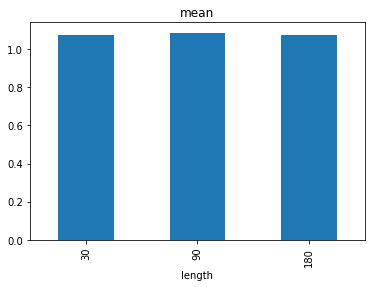

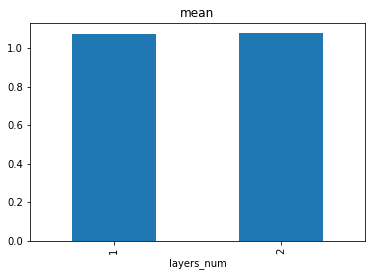

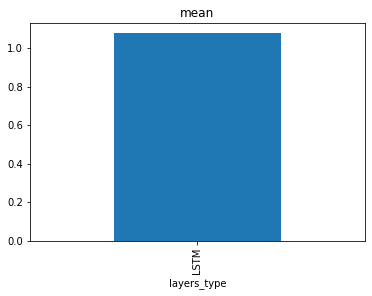

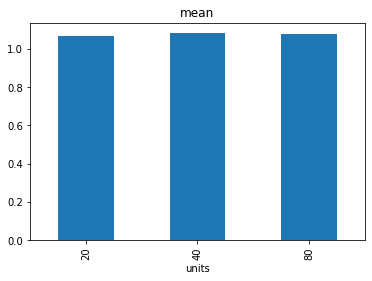

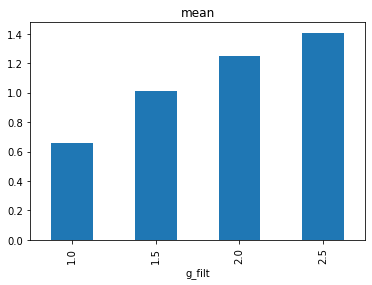

In [ ]:
gs.groupby('length')['val_mae_og'].mean().plot(kind='bar', title='mean'); plt.show()
gs.groupby('layers_num')['val_mae_og'].mean().plot(kind='bar', title='mean'); plt.show()
gs.groupby('layers_type')['val_mae_og'].mean().plot(kind='bar', title='mean'); plt.show()
gs.groupby('units')['val_mae_og'].mean().plot(kind='bar', title='mean'); plt.show()
gs.groupby('g_filt')['val_mae_og'].mean().plot(kind='bar', title='mean'); plt.show()

That's much better compared to last time!

The model was more able to pick out the trends it needed with less noise in the data.

Performance is mostly influenced by our smoothing factor.

The other hyperparameters are of little consequence it seems.

Performance decreases the more we smooth. The model fits onto something that
is too far removed from the real series. The signal is altered so much that it does not reflect the underlying data anymore.

So we need some smoothing but not too much!

## Recreate the best model and compare against test data

In [ ]:
best_model_params = gs.sort_values('val_mae_og').iloc[0]
best_model_params

length               30
layers_num            1
layers_type        LSTM
units                80
g_filt                1
loss             0.1754
mae              0.3299
val_loss         0.1701
val_mae          0.3237
val_mae_og     0.635011
epochs               61
Name: 8, dtype: object

In [ ]:
best_model = BuildModel(model_name='best_temp_smooth_model.h5', length=30, layers_num=1,\
                        layers_type='LSTM', units=80, dropout=0, g_filt=1, epochs=120, batch_size=10,\
                        patience=10)

best_model.setupData(temp_train)
best_model.fitModel()

Epoch 1/120
192/192 [==============================] - 34s 7ms/step - loss: 53.5142 - mae: 5.6720 - val_loss: 7.5169 - val_mae: 2.1209
Epoch 2/120
192/192 [==============================] - 1s 5ms/step - loss: 5.4025 - mae: 1.8085 - val_loss: 3.6308 - val_mae: 1.3941
Epoch 3/120
192/192 [==============================] - 1s 5ms/step - loss: 2.4684 - mae: 1.1938 - val_loss: 2.3300 - val_mae: 1.1267
Epoch 4/120
192/192 [==============================] - 1s 5ms/step - loss: 1.7580 - mae: 0.9879 - val_loss: 1.7809 - val_mae: 0.9747
Epoch 5/120
192/192 [==============================] - 1s 5ms/step - loss: 1.5430 - mae: 0.9333 - val_loss: 1.4295 - val_mae: 0.9045
Epoch 6/120
192/192 [==============================] - 1s 5ms/step - loss: 1.1294 - mae: 0.8046 - val_loss: 1.1499 - val_mae: 0.8023
Epoch 7/120
192/192 [==============================] - 1s 5ms/step - loss: 0.9144 - mae: 0.7257 - val_loss: 0.8554 - val_mae: 0.6867
Epoch 8/120
192/192 [==============================] - 1s 5ms/step 

In [ ]:
#load best performer
best_model.loadModel()

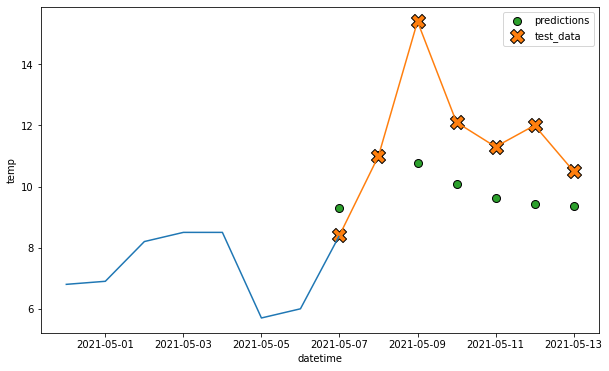

In [ ]:
#predict a week
week_pred = best_model.predAhead(7)

#plot against test week
best_model.plotPreds(week_pred, temp_test, ylabel='temp')

Now that is much better compared to the previous notebook!

The first value is pretty close to its target and the second is even right on it! Given that the model is only supposed to predict one step into the future, I am quite pleased with this.

The other predictions are built upon the predictions that came before them and so we can expect greater error as we predict further into the future.

This model can now be deployed with the API feeding it live data.

The other weather variables are modelled in yet more notebooks that are going to be rather similar to this one.